<h2>MODEL DEFINITION, TRAINING AND DEPLOYMENT NOTEBOOK</h2>

In [1]:
#Install PySpark
!pip install pyspark==2.4.5

Now let's import PySpark modules.

In [2]:
#Import PySpark libraries
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

Let's create Spark instance.

In [3]:
#Create Spark instance
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

Now we read the final parquet file into Spark and create a dataframe instance.

In [4]:
#Read parquet file as a Spark dataframe
df = spark.read.parquet('df_final.parquet')
df.createOrReplaceTempView('sensor_data')

#Display statistical description of the dataframe
df.describe().show()

+-------+------------------+--------------------+------------------+--------------------+--------------------+
|summary|          humidity|               smoke|              temp|         light_final|        motion_final|
+-------+------------------+--------------------+------------------+--------------------+--------------------+
|  count|            187451|              187451|            187451|              187451|              187451|
|   mean| 50.81407674538176|0.022288350217858362|22.279969165276523|0.016009517153816197| 7.68200756464356E-4|
| stddev|1.8889262809920346|0.001720104166737...|0.4819022291417346| 0.12551213707790115|0.027705860735184988|
|    min|              45.1|0.019416273090454256|              21.0|                   0|                   0|
|    max|              63.3| 0.02942197406197568|              24.1|                   1|                   1|
+-------+------------------+--------------------+------------------+--------------------+--------------------+



Let's check if the dataframe is the right one by printing it.

In [5]:
#Display first 20 records of the dataframe
df.show()

+--------+--------------------+----+-----------+------------+
|humidity|               smoke|temp|light_final|motion_final|
+--------+--------------------+----+-----------+------------+
|    51.0| 0.02041127012241292|22.7|          0|           0|
|    50.9| 0.02047512557617824|22.6|          0|           0|
|    50.9|0.020447620810233658|22.6|          0|           0|
|    50.9|0.020475166204362245|22.6|          0|           0|
|    50.9| 0.02045681960706413|22.6|          0|           0|
|    50.9| 0.02042485815208522|22.6|          0|           0|
|    50.9|0.020461237669931027|22.6|          0|           0|
|    50.9|0.020438716650667384|22.6|          0|           0|
|    50.9|0.020475033620232192|22.6|          0|           0|
|    50.9| 0.02042485815208522|22.6|          0|           0|
|    50.9| 0.02041184473336307|22.6|          0|           0|
|    50.8|  0.0203978759436991|22.6|          0|           0|
|    50.9| 0.02042943583639171|22.6|          0|           0|
|    50.

From the graphs in the **Data Exploration Notebook** we observed that the records where motion is detected is very sparse.<br>
This is an issue commonly referred to as *data imbalance*.<br>
<br>
Hence, the ML model will simply learn to provide 0 as output since that will still provide 95%+ accuracy.<br>
We do not want that, hence we *balance* the data by **sampling the data** such that the data is balanced.<br>
<br>
We start off by getting details about the records having 1 as motion_final.

In [6]:
#Filter the dataframe into a new dataframe df_1 which contains only the records where motion_final is 1
df_1 = df.where((df.motion_final == 1))

#Display statistical description of the new dataframe df_1
df_1.describe().show()

+-------+------------------+--------------------+------------------+-------------------+------------+
|summary|          humidity|               smoke|              temp|        light_final|motion_final|
+-------+------------------+--------------------+------------------+-------------------+------------+
|  count|               144|                 144|               144|                144|         144|
|   mean| 50.32569444444445|0.022065659524688867|22.278472222222213|0.04861111111111111|         1.0|
| stddev|1.7420647875910713| 0.00184460745334887| 0.391547618667941|0.21580427259784288|         0.0|
|    min|              46.1| 0.01988092642782673|              21.6|                  0|           1|
|    max|              54.6|0.027508421103950638|              23.4|                  1|           1|
+-------+------------------+--------------------+------------------+-------------------+------------+



Now we observe that 144 records have 1 as motion_final.<br>
Hence, we need to sample the values that have 0 as motion_final such that the sampled values have approx 144 values as well.<br>
<br>
We accomplish this by using a sampling rate of 0.0008 on the data where motion_final is 0.

In [7]:
#Filter the main dataframe again into a new dataframe df_2 which contains only the records where motion_final is 0 and randomly sample only 0.08% of it to roughly obtain 150 records
df_2 = df.where((df.motion_final == 0)).sample(False, 0.0008)
df_2.describe().show()

+-------+-----------------+--------------------+------------------+-------------------+------------+
|summary|         humidity|               smoke|              temp|        light_final|motion_final|
+-------+-----------------+--------------------+------------------+-------------------+------------+
|  count|              160|                 160|               160|                160|         160|
|   mean|        50.845625|0.022506956236353994|22.285000000000004|            0.00625|         0.0|
| stddev|1.897825530780694|0.001751438845133...| 0.450045420489027|0.07905694150420947|         0.0|
|    min|             46.2|0.020041577054495552|              21.2|                  0|           0|
|    max|             54.6| 0.02749299762823611|              23.9|                  1|           0|
+-------+-----------------+--------------------+------------------+-------------------+------------+



Now that we have both the processed dataframes, we can go ahead and **merge** them.

In [8]:
#Merge df_1 and df_2 to create a new dataframe df_final
df_final = df_1.unionAll(df_2)

Let's check the statistics of the merged dataframe.

In [9]:
#Display the statistical description of the merged dataframe
df_final.describe().show()

+-------+-----------------+--------------------+-------------------+-------------------+-------------------+
|summary|         humidity|               smoke|               temp|        light_final|       motion_final|
+-------+-----------------+--------------------+-------------------+-------------------+-------------------+
|  count|              304|                 304|                304|                304|                304|
|   mean|50.59934210526316|0.022297920951881038|  22.28190789473684|0.02631578947368421|0.47368421052631576|
| stddev|1.841168258428614|0.001806722377284...|0.42266830155428814| 0.1603366269487071| 0.5001302592180493|
|    min|             46.1| 0.01988092642782673|               21.2|                  0|                  0|
|    max|             54.6|0.027508421103950638|               23.9|                  1|                  1|
+-------+-----------------+--------------------+-------------------+-------------------+-------------------+



In [10]:
#Display first 20 records of the merged dataframe
df_final.show()

+--------+--------------------+----+-----------+------------+
|humidity|               smoke|temp|light_final|motion_final|
+--------+--------------------+----+-----------+------------+
|    51.8|0.019998137876408518|22.2|          0|           1|
|    51.8|0.020032820812921674|22.3|          0|           1|
|    51.9|0.020020009199106837|22.3|          0|           1|
|    52.0| 0.01999377048749705|22.3|          0|           1|
|    52.0|  0.0200546885263529|22.3|          0|           1|
|    51.9| 0.02005924556696428|22.2|          0|           1|
|    51.9|0.020024037643655297|22.2|          0|           1|
|    51.1|0.020063629996772667|22.2|          0|           1|
|    50.6| 0.02004151412273946|22.2|          0|           1|
|    49.5|0.020024037643655297|21.8|          0|           1|
|    50.0|0.020059071769776702|21.8|          0|           1|
|    50.1| 0.02010314137587005|21.8|          0|           1|
|    50.1|0.020045893936615555|21.8|          0|           1|
|    51.

Since the dataframes were merged vertically, the data is split internally and hence may result in bad performance while trained.<br>
<br>
Hence we **shuffle** the dataframe to maintain data diversity.

In [11]:
#Import module which enables random shuffling of Spark dataframe
from pyspark.sql.functions import rand

#Randomly shuffle the records of the dataframe and name it df
df = df_final.orderBy(rand())
df.show()

+--------+--------------------+----+-----------+------------+
|humidity|               smoke|temp|light_final|motion_final|
+--------+--------------------+----+-----------+------------+
|    51.2|0.024295005792873352|22.4|          0|           0|
|    46.5| 0.02106923987802722|23.9|          0|           0|
|    46.3|0.021209358505977532|23.7|          0|           0|
|    52.6|0.020543606849059416|22.8|          0|           1|
|    52.3|0.024756113729318914|21.6|          0|           1|
|    52.8| 0.02388495395368051|21.9|          0|           0|
|    51.8|0.019998137876408518|22.2|          0|           1|
|    52.1|0.020534427566983336|22.5|          0|           0|
|    47.0|0.021828032423057725|23.2|          0|           0|
|    52.2| 0.02352238795170069|21.9|          0|           0|
|    52.2| 0.02481460282330909|21.7|          0|           1|
|    51.5|0.020316591192420567|22.7|          0|           0|
|    50.4|0.024177195138253855|21.8|          0|           1|
|    47.

<h3>Perfect!</h3>
Now that the dataframe is ready, we can proceed to feed it into the ML models.<br>
<br>
But, first off we have to define the ML models:<br>
1. Classifiers<br>
   - Gradient Boosted Trees<br>
   - Logistic Regression<br>   
2. Deep learning Model

Let's go ahead and define the **pipelines** for the classification models *with* and *without StandardScaler* to compare the performance.

In [12]:
#Import VectorAssembler module
from pyspark.ml.feature import VectorAssembler

#Define an instance of VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ["humidity","smoke","temp","light_final"], outputCol = "features")

In [13]:
#Import StandardScaler module
from pyspark.ml.feature import StandardScaler

#Define an instance of StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="features_final", withStd=True, withMean=False)

In [14]:
#Import ML classification modules
from pyspark.ml.classification import GBTClassifier, LogisticRegression

#Create instances of the two classification modules which are used with StandardScaler
gbt_classifier_wscaler = GBTClassifier(labelCol = "motion_final", featuresCol = "features_final", maxIter = 10)
lr_classifier_wscaler = LogisticRegression(labelCol = "motion_final", featuresCol = "features_final", maxIter=10, regParam=0.3, elasticNetParam=0.8)

#Create instances of the two classification modules which do not use StandardScaler
gbt_classifier_woscaler = GBTClassifier(labelCol = "motion_final", featuresCol = "features", maxIter = 10)
lr_classifier_woscaler = LogisticRegression(labelCol = "motion_final", featuresCol = "features", maxIter=10, regParam=0.3, elasticNetParam=0.8)


In [15]:
#Import Pipeline module
from pyspark.ml import Pipeline

#Define pipelines for the two classification modules with StandardScaler
pipeline_gbt_wscaler = Pipeline(stages=[vectorAssembler,scaler, gbt_classifier_wscaler])
pipeline_lr_wscaler = Pipeline(stages=[vectorAssembler,scaler, lr_classifier_wscaler])

#Define pipelines for the two classification modules without StandardScaler
pipeline_gbt_woscaler = Pipeline(stages=[vectorAssembler, gbt_classifier_woscaler])
pipeline_lr_woscaler = Pipeline(stages=[vectorAssembler, lr_classifier_woscaler])

Now that the pipelines are defined, we can go ahead and fit the dataframe into the pipelines and train the models.

In [16]:
#Fit the dataframe to the defined pipelines 

model_gbt_wscaler = pipeline_gbt_wscaler.fit(df)
model_gbt_woscaler = pipeline_gbt_woscaler.fit(df)

model_lr_wscaler = pipeline_lr_wscaler.fit(df)
model_lr_woscaler = pipeline_lr_woscaler.fit(df)

In [17]:
#Transform the dataframes by predicting motion_light using the fitted classification modules

prediction_gbt_wscaler = model_gbt_wscaler.transform(df)
prediction_gbt_woscaler = model_gbt_woscaler.transform(df)

prediction_lr_wscaler = model_lr_wscaler.transform(df)
prediction_lr_woscaler = model_lr_woscaler.transform(df)

In [18]:
#Display the dataframe which predicted the output using GBT with StandardScaler
prediction_gbt_wscaler.show()

+--------+--------------------+----+-----------+------------+--------------------+--------------------+--------------------+--------------------+----------+
|humidity|               smoke|temp|light_final|motion_final|            features|      features_final|       rawPrediction|         probability|prediction|
+--------+--------------------+----+-----------+------------+--------------------+--------------------+--------------------+--------------------+----------+
|    51.2|0.024295005792873352|22.4|          0|           0|[51.2,0.024295005...|[27.8084307426078...|[0.68927406000974...|[0.79875772073736...|       0.0|
|    46.5| 0.02106923987802722|23.9|          0|           0|[46.5,0.021069239...|[25.2557037017825...|[1.09974497999146...|[0.90020369976792...|       0.0|
|    46.3|0.021209358505977532|23.7|          0|           0|[46.3,0.021209358...|[25.1470770191941...|[1.09974497999146...|[0.90020369976792...|       0.0|
|    52.6|0.020543606849059416|22.8|          0|          

In [19]:
#Display the dataframe which predicted the output using GBT without StandardScaler
prediction_gbt_woscaler.show()

+--------+--------------------+----+-----------+------------+--------------------+--------------------+--------------------+----------+
|humidity|               smoke|temp|light_final|motion_final|            features|       rawPrediction|         probability|prediction|
+--------+--------------------+----+-----------+------------+--------------------+--------------------+--------------------+----------+
|    51.2|0.024295005792873352|22.4|          0|           0|[51.2,0.024295005...|[0.68927406000974...|[0.79875772073736...|       0.0|
|    46.5| 0.02106923987802722|23.9|          0|           0|[46.5,0.021069239...|[1.09974497999146...|[0.90020369976792...|       0.0|
|    46.3|0.021209358505977532|23.7|          0|           0|[46.3,0.021209358...|[1.09974497999146...|[0.90020369976792...|       0.0|
|    52.6|0.020543606849059416|22.8|          0|           1|[52.6,0.020543606...|[-0.1763362257346...|[0.41273450892821...|       1.0|
|    52.3|0.024756113729318914|21.6|          0|

In [20]:
#Display the dataframe which predicted the output using LogisticRegression with StandardScaler
prediction_lr_wscaler.show()

+--------+--------------------+----+-----------+------------+--------------------+--------------------+--------------------+--------------------+----------+
|humidity|               smoke|temp|light_final|motion_final|            features|      features_final|       rawPrediction|         probability|prediction|
+--------+--------------------+----+-----------+------------+--------------------+--------------------+--------------------+--------------------+----------+
|    51.2|0.024295005792873352|22.4|          0|           0|[51.2,0.024295005...|[27.8084307426078...|[0.10536051565782...|[0.52631578947368...|       0.0|
|    46.5| 0.02106923987802722|23.9|          0|           0|[46.5,0.021069239...|[25.2557037017825...|[0.10536051565782...|[0.52631578947368...|       0.0|
|    46.3|0.021209358505977532|23.7|          0|           0|[46.3,0.021209358...|[25.1470770191941...|[0.10536051565782...|[0.52631578947368...|       0.0|
|    52.6|0.020543606849059416|22.8|          0|          

In [21]:
#Display the dataframe which predicted the output using LogisticRegression without StandardScaler
prediction_lr_woscaler.show()

+--------+--------------------+----+-----------+------------+--------------------+--------------------+--------------------+----------+
|humidity|               smoke|temp|light_final|motion_final|            features|       rawPrediction|         probability|prediction|
+--------+--------------------+----+-----------+------------+--------------------+--------------------+--------------------+----------+
|    51.2|0.024295005792873352|22.4|          0|           0|[51.2,0.024295005...|[0.10536051565782...|[0.52631578947368...|       0.0|
|    46.5| 0.02106923987802722|23.9|          0|           0|[46.5,0.021069239...|[0.10536051565782...|[0.52631578947368...|       0.0|
|    46.3|0.021209358505977532|23.7|          0|           0|[46.3,0.021209358...|[0.10536051565782...|[0.52631578947368...|       0.0|
|    52.6|0.020543606849059416|22.8|          0|           1|[52.6,0.020543606...|[0.10536051565782...|[0.52631578947368...|       0.0|
|    52.3|0.024756113729318914|21.6|          0|

We can observe the *prediction* column in the predicted dataframes containing the values predicted by the models.<br>
<br>
Now we can go ahead and **evaluate** the performance of the models.

In [22]:
#Import module used for model evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#Create instance of the evaluator which evaluates the models based on accuracy
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy").setPredictionCol("prediction").setLabelCol("motion_final")

#Use the created instance to evaluate all the models

gbt_acc_wscaler = binEval.evaluate(prediction_gbt_wscaler)
gbt_acc_woscaler = binEval.evaluate(prediction_gbt_woscaler)

lr_acc_wscaler = binEval.evaluate(prediction_lr_wscaler)
lr_acc_woscaler = binEval.evaluate(prediction_lr_woscaler)

Now we can move on to the *deep-learning model* using **keras** modules.

In [23]:
#Import necessary modules required to implement a DNN

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout

Using TensorFlow backend.


Since the modules are imported, we now define the neural-network models for data both *scaled* and *unscaled* data.

In [24]:
#Construct a neural network model that uses scaled data

model_nn_wscaler = Sequential()

model_nn_wscaler.add(Dense(output_dim = 32, init = 'uniform', activation = 'relu', input_dim = 4))
#model_nn.add(Dropout(0.2))
model_nn_wscaler.add(Dense(64, init = 'uniform', activation = 'relu'))

#output layer with 1 output neuron which will predict 1 or 0
model_nn_wscaler.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=4, units=32, kernel_initializer="uniform")`
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`


In [25]:
#Construct a neural network model that uses unscaled data

model_nn_woscaler = Sequential()

model_nn_woscaler.add(Dense(output_dim = 32, init = 'uniform', activation = 'relu', input_dim = 4))
#model_nn.add(Dropout(0.2))
model_nn_woscaler.add(Dense(64, init = 'uniform', activation = 'relu'))

#output layer with 1 output neuron which will predict 1 or 0
model_nn_woscaler.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=4, units=32, kernel_initializer="uniform")`
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`


We now set the **hyperparameters** for the optimizer we are using and *compile* the models.

In [26]:
#Adjust ADAM parameters
keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [27]:
#Compile both the models

model_nn_wscaler.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_nn_woscaler.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Now we go ahead and prepare *training data* to train the models respectively.

In [28]:
#Prepare training data

import numpy as np

X_train_wscaler = np.array(prediction_lr_wscaler.select('features_final').rdd.flatMap(lambda x:x).collect())
X_train_woscaler = np.array(prediction_lr_woscaler.select('features').rdd.flatMap(lambda x:x).collect())

y_train = df.select('motion_final').rdd.flatMap(lambda x:x).collect()

In [29]:
X_train_wscaler

array([[27.80843074, 13.44700553, 52.99664043,  0.        ],
       [25.2557037 , 11.66158129, 56.54552261,  0.        ],
       [25.14707702, 11.73913534, 56.07233832,  0.        ],
       ...,
       [28.02568411, 13.47793162, 53.23323258,  0.        ],
       [28.07999745, 11.62708562, 52.52345614,  0.        ],
       [27.04804396, 12.66153213, 52.286864  ,  0.        ]])

Now that both the models and the data are ready, we can move ahead to *model training*.<br>

In [30]:
#Train the model that uses scaled data

model_nn_wscaler.fit(X_train_wscaler, y_train, epochs = 10, validation_split = 0.2)

Instructions for updating:
Use tf.cast instead.
Train on 243 samples, validate on 61 samples
Epoch 1/10
243/243 [==============================] - 3s 13ms/step - loss: 0.6937 - acc: 0.4856 - val_loss: 0.6919 - val_acc: 0.5410
Epoch 2/10
243/243 [==============================] - 1s 4ms/step - loss: 0.6926 - acc: 0.5226 - val_loss: 0.6914 - val_acc: 0.5410
Epoch 3/10
243/243 [==============================] - 1s 2ms/step - loss: 0.6921 - acc: 0.5226 - val_loss: 0.6908 - val_acc: 0.5410
Epoch 4/10
243/243 [==============================] - 1s 3ms/step - loss: 0.6921 - acc: 0.5226 - val_loss: 0.6903 - val_acc: 0.5410
Epoch 5/10
243/243 [==============================] - 8s 32ms/step - loss: 0.6928 - acc: 0.5226 - val_loss: 0.6905 - val_acc: 0.5410
Epoch 6/10
243/243 [==============================] - 1s 3ms/step - loss: 0.6925 - acc: 0.5226 - val_loss: 0.6901 - val_acc: 0.5410
Epoch 7/10
243/243 [==============================] - 1s 3ms/step - loss: 0.6932 - acc: 0.5226 - val_loss: 0.6899

In [31]:
#Train the model that uses unscaled data

model_nn_woscaler.fit(X_train_woscaler, y_train, epochs = 10, validation_split = 0.2)

Train on 243 samples, validate on 61 samples
Epoch 1/10
243/243 [==============================] - 2s 7ms/step - loss: 0.6934 - acc: 0.5226 - val_loss: 0.6896 - val_acc: 0.5410
Epoch 2/10
243/243 [==============================] - 1s 3ms/step - loss: 0.6922 - acc: 0.5226 - val_loss: 0.6900 - val_acc: 0.5410
Epoch 3/10
243/243 [==============================] - 2s 8ms/step - loss: 0.6921 - acc: 0.5226 - val_loss: 0.6903 - val_acc: 0.5410
Epoch 4/10
243/243 [==============================] - 1s 3ms/step - loss: 0.6923 - acc: 0.5226 - val_loss: 0.6909 - val_acc: 0.5410
Epoch 5/10
243/243 [==============================] - 5s 19ms/step - loss: 0.6925 - acc: 0.5226 - val_loss: 0.6907 - val_acc: 0.5410
Epoch 6/10
243/243 [==============================] - 4s 16ms/step - loss: 0.6921 - acc: 0.5226 - val_loss: 0.6905 - val_acc: 0.5410
Epoch 7/10
243/243 [==============================] - 1s 3ms/step - loss: 0.6922 - acc: 0.5226 - val_loss: 0.6901 - val_acc: 0.5410
Epoch 8/10
243/243 [=========

In [32]:
#Evaluate the model that uses scaled data

evaluate_nn_wscaler = model_nn_wscaler.evaluate(X_train_wscaler, y_train)
nn_acc_wscaler = evaluate_nn_wscaler[1]

304/304 [==============================] - 0s 369us/step


In [33]:
#Evaluate the model that uses unscaled data

evaluate_nn_woscaler = model_nn_woscaler.evaluate(X_train_woscaler, y_train)
nn_acc_woscaler = evaluate_nn_woscaler[1]

304/304 [==============================] - 0s 372us/step


In [34]:
#Use the trained models to predict values for motion_final

prediction_nn_wscaler = model_nn_wscaler.predict(X_train_wscaler)
prediction_nn_woscaler = model_nn_woscaler.predict(X_train_woscaler)

Let's examine the accuracy obtained by all the models.

In [35]:
#Print the accuracy of all three models that used scaled data

print("Accuracy of prediction by GBT Classifier with data normalisation is",gbt_acc_wscaler)
print()
print("Accuracy of prediction by Logistic Regression with data normalisation is",lr_acc_wscaler)
print()
print("Accuracy of prediction by Neural Network model with data normalisation is",nn_acc_wscaler)

Accuracy of prediction by GBT Classifier with data normalisation is 0.881578947368421

Accuracy of prediction by Logistic Regression with data normalisation is 0.5263157894736842

Accuracy of prediction by Neural Network model with data normalisation is 0.5460526315789473


In [36]:
#Print the accuracy of all three models that used unscaled data

print("Accuracy of prediction by GBT Classifier without data normalisation is",gbt_acc_woscaler)
print()
print("Accuracy of prediction by Logistic Regression without data normalisation is",lr_acc_woscaler)
print()
print("Accuracy of prediction by Neural Network model without data normalisation is",nn_acc_woscaler)

Accuracy of prediction by GBT Classifier without data normalisation is 0.881578947368421

Accuracy of prediction by Logistic Regression without data normalisation is 0.5263157894736842

Accuracy of prediction by Neural Network model without data normalisation is 0.5263157894736842


We notice that both the *logistic regression model* as well as the *neural network model* have the same accruracy of 50.5% which is pretty low.<br>
Now we can scroll up to look at the predictions of both these models and notice that both are prediction **0 for all values**.<br>
We infer that both these models have learnt to provide 0 as output always and hence there is no useful prediction happening.<br>
<br>
On the other hand, the *gradient boosted trees classifier* is performing as expected with an accuracy of 90.7% which is decent enough.<br>
Hence, we can conclude that **gradient boosted trees classifier** is more robust to data imbalance.<br>
<br>
Also, while comparing the results *with* and *without scaling the data*, we notice that there is not much difference in the performance of both models.<br>
This could be justfied by the good quality of the dataset.<br>
<br>
Now we can go ahead and obtain the **F1 score** of these models to understand how well they are performing.

In [37]:
#Print F1 score of all three models that used scaled data

from sklearn.metrics import f1_score

log_f1 = f1_score(prediction_lr_wscaler.select('motion_final').collect(), prediction_lr_wscaler.select('prediction').collect())
print("The F1 score for logistic regressor model with data normalisation is:",log_f1)
print()
gbt_f1 = f1_score(prediction_gbt_wscaler.select('motion_final').collect(), prediction_gbt_wscaler.select('prediction').collect())
print("The F1 score for GBT model with data normalisation is:",gbt_f1)
print()
nn_f1 = f1_score(y_train, model_nn_wscaler.predict_classes(X_train_wscaler).reshape((-1,)))
print("The F1 score of the neural network with data normalisation is:",nn_f1)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


The F1 score for logistic regressor model with data normalisation is: 0.0

The F1 score for GBT model with data normalisation is: 0.8758620689655173

The F1 score of the neural network with data normalisation is: 0.09210526315789473


In [38]:
#Print F1 score of all three models that used unscaled data

log_f1 = f1_score(prediction_lr_woscaler.select('motion_final').collect(), prediction_lr_woscaler.select('prediction').collect())
print("The F1 score for logistic regressor model without data normalisation is:",log_f1)
print()
gbt_f1 = f1_score(prediction_gbt_woscaler.select('motion_final').collect(), prediction_gbt_woscaler.select('prediction').collect())
print("The F1 score for GBT model without data normalisation is:",gbt_f1)
print()
nn_f1 = f1_score(y_train, model_nn_woscaler.predict_classes(X_train_woscaler).reshape((-1,)))
print("The F1 score of the neural network without data normalisation is:",nn_f1)

The F1 score for logistic regressor model without data normalisation is: 0.0

The F1 score for GBT model without data normalisation is: 0.8758620689655173

The F1 score of the neural network without data normalisation is: 0.0


As expected, only the *gbt classifier* has an F1 score and the other two have 0.<br>
<br>
Hence, we can now do further evaluation of the *gbt classifier* alone using **confusion matrix**.

In [39]:
#Form the confusion matrix for the GBT Classifier's performance

from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = prediction_gbt_wscaler.select('prediction').rdd.flatMap(lambda x:x).collect()
cf_matrix = confusion_matrix(y_train, y_pred)
print(cf_matrix)

[[141  19]
 [ 17 127]]


Text(0.5, 1.0, 'Confusion Matrix\n')

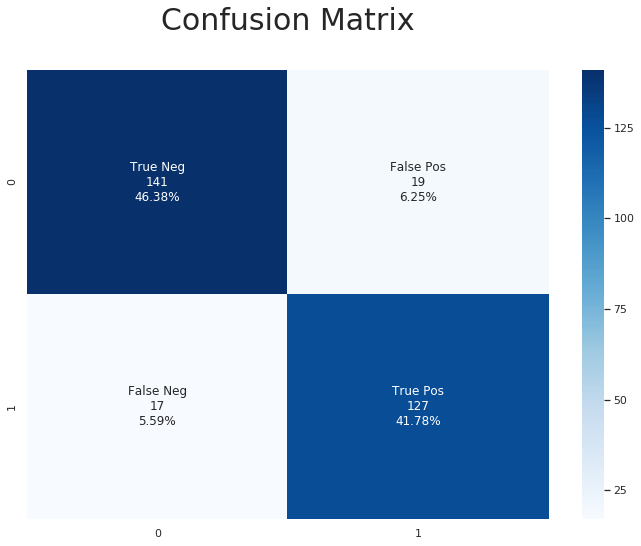

In [40]:
#Plot the confusion matrix

sns.set(rc={'figure.figsize':(11.7,8.27), "axes.titlesize":30})
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues').set_title('Confusion Matrix\n')